## Librerías

In [1]:
import pandas as pd; import matplotlib.pyplot as plt; import numpy as np; import seaborn as sns; from copy import deepcopy

## Lectura y preprocesamiento de los datos

In [2]:
df = pd.read_csv('co_properties.csv')

### Estilos para los gráficos

In [3]:
##Estilos
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

In [4]:
##Tamaño del dataset y datos faltantes

print(f'Dataset size: {df.shape[0]} rows and {df.shape[1]} columns\n')

def missing_values(df):
    missing_percentage = {}
    for i,col in enumerate(df):
        missing_percentage[col] = df[col].isna().sum()/df.shape[0]*100
    
    over_30_percent = {}
    for key, value in missing_percentage.items():
        if value>30:
            over_30_percent[key] = value
    print(f'There are {len(over_30_percent)} columns with over 30% of missing values'.center(70,'-'))
    
    for key,value in missing_percentage.items():
        print(f'{key} = {value:.2f}%')
    return over_30_percent
delete_columns = missing_values(df).keys()

Dataset size: 1000000 rows and 25 columns

---------There are 8 columns with over 30% of missing values----------
id = 0.00%
ad_type = 0.00%
start_date = 0.00%
end_date = 0.00%
created_on = 0.00%
lat = 25.97%
lon = 25.97%
l1 = 0.00%
l2 = 0.00%
l3 = 6.28%
l4 = 72.60%
l5 = 84.09%
l6 = 94.53%
rooms = 82.79%
bedrooms = 62.40%
bathrooms = 20.05%
surface_total = 95.88%
surface_covered = 94.01%
price = 0.05%
currency = 0.06%
price_period = 87.88%
title = 0.00%
description = 0.06%
property_type = 0.00%
operation_type = 0.00%


#### Análisis iniciales
1. El dataset tiene 25 columnas. 
2. Hay 8 columnas con más del 30% de datos faltantes. Estas serán descartadas del análisis general pero serán trabajadas en el análisis específico.
3. La columna created_on tiene los mismos datos de la columna star_date por lo cual será descartada.
4. La columna id es irrelevante para el análisis.
5. Las columnas title y description generan conflicto puesto que son strings sin un formato específico de escritura por lo cual serán descartadas.
6. La columna ad_type, currency y l1 solo tienen un valor por lo cual serán descartadas.
7. La columna end_date tiene fechas más allá de 2024 lo cual no tiene sentido. Serán descartados valores más allá de 2024.
8. Los valores faltantes de las demás columnas serán llenados con la moda en caso de ser categórica, o con el promedio en caso de ser numérica.

In [5]:
df_gen = df.drop(columns=delete_columns).drop(columns=['id','created_on','title','description','ad_type','l1','currency'])

df_gen = df_gen.loc[df_gen['operation_type']!='Arriendo temporal']

new_names = {'l2':'State','l3':'City'}

df_gen = df_gen.rename(columns=new_names)

filling_dictionary = {'bathrooms':df_gen['bathrooms'].mean(),
                      'City':df_gen['City'].mode()[0],
                      'price':df_gen['price'].mean(),}

df_gen = df_gen.fillna(filling_dictionary)

##Conversión de tipos de datos

df_gen['start_date'] = pd.to_datetime(df_gen['start_date'])
df_gen = df_gen[df_gen['end_date']<'2025']

df_gen['end_date'] = pd.to_datetime(df_gen['end_date'])

df_gen['price'] = df_gen['price']/1000000
df_gen['price'] = df_gen['price'].astype(np.float64)
df_gen['bathrooms'] = df_gen['bathrooms'].astype(np.int32)

In [6]:
##Verificar valores atípicos. Aquellos valores por encima del rango intercuartílico (IQR) serán reemplazados por el valor máximo del rango IQR.
##Aquellos valores por debajo del IQR serán reemplazados por el valor mínimo del rango.


q1_sell = df_gen.loc[df_gen['operation_type']=='Venta']['price'].quantile(0.25)
q3_sell = df_gen.loc[df_gen['operation_type']=='Venta']['price'].quantile(0.75)
iqr_sell = q3_sell - q1_sell

q1_rent = df_gen.loc[df_gen['operation_type']=='Arriendo']['price'].quantile(0.25)
q3_rent = df_gen.loc[df_gen['operation_type']=='Arriendo']['price'].quantile(0.75)
iqr_rent = q3_rent - q1_rent

df_gen.loc[(df_gen['operation_type']=='Venta')&(df_gen['price']>q3_sell + 1.5*iqr_sell),'price'] = iqr_sell*1.5
df_gen.loc[(df_gen['operation_type']=='Arriendo')&(df_gen['price']>q3_rent + 1.5*iqr_rent),'price'] = iqr_rent*1.5

df_gen.loc[(df_gen['operation_type']=='Venta')&(df_gen['price']<q1_sell - 1.5*iqr_sell),'price'] = iqr_sell*1.5
df_gen.loc[(df_gen['operation_type']=='Arriendo')&(df_gen['price']<q1_rent - 1.5*iqr_rent),'price'] = iqr_rent*1.5


In [7]:
##Cálculo de columnas derivadas

##Cantidad de días hasta que la casa se vendió

df_gen['sold_after'] = (df_gen['end_date'] - df_gen['start_date']).dt.days

##Reclasificación de las columnas que tienen demasiados valores diferentes.

too_much_uniques = ['City','State','property_type']
def reclass_unique_values(too_much_uniques,df=df_gen.copy()):
    
    for i in range(len(too_much_uniques)):
        main = df[too_much_uniques[i]].value_counts(normalize=True,sort=True).head(5).index
        df['Main_'+too_much_uniques[i]] = False
        df.loc[df[too_much_uniques[i]].isin(main),'Main_'+too_much_uniques[i]]=True
        df.loc[df['Main_'+too_much_uniques[i]]==False,too_much_uniques[i]]='Others'
        df = df.drop(columns='Main_'+too_much_uniques[i])
    return df

df_gen2 = reclass_unique_values(too_much_uniques)
df_gen2['property_type'] = df_gen2['property_type'].str.replace('Otro','Others')

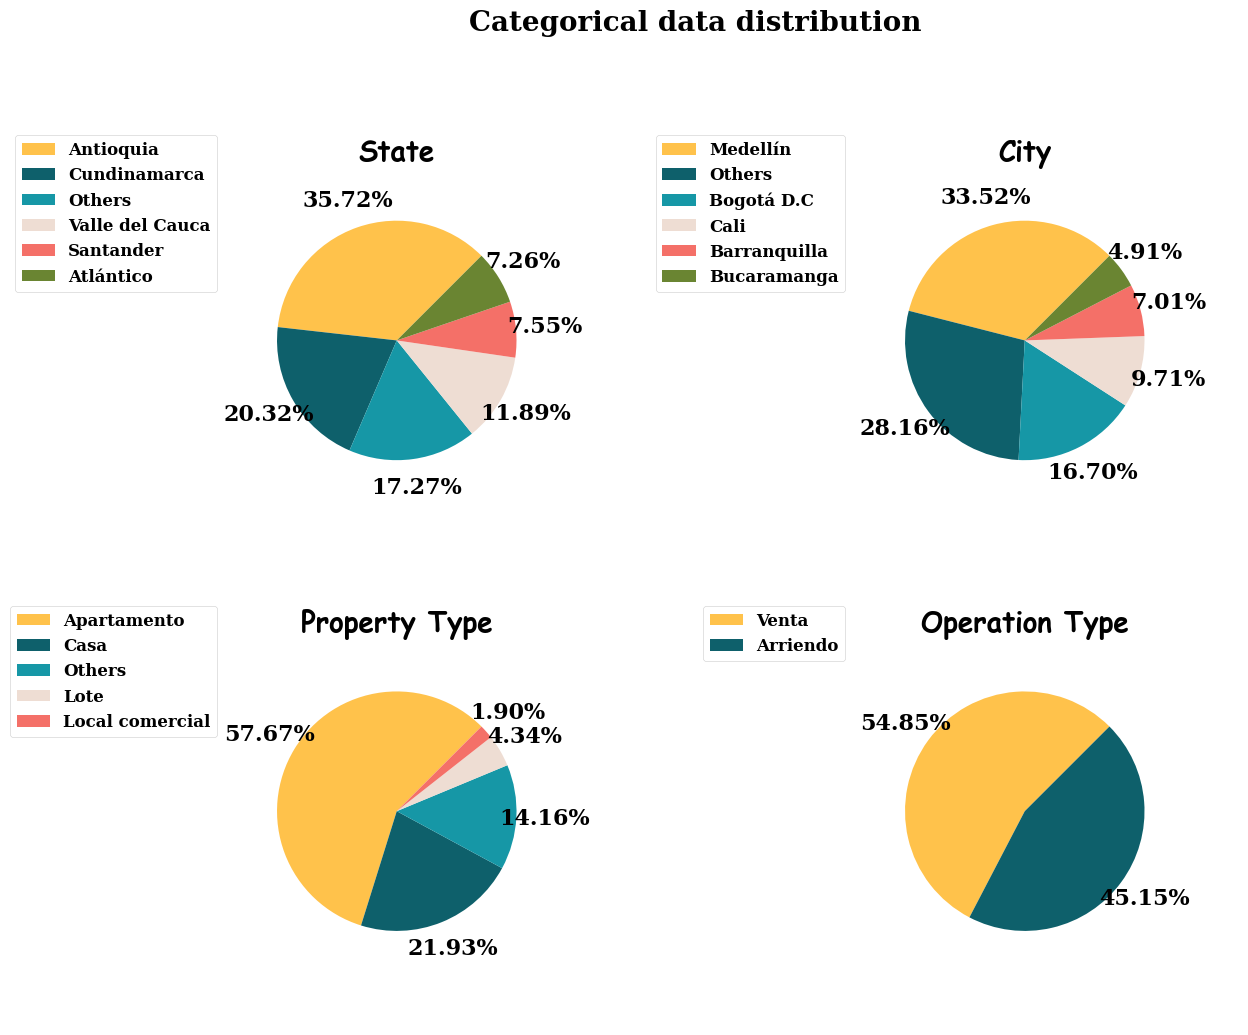

In [8]:
##Distribución de los datos categóricos

cat = df_gen2.select_dtypes('O')
colors = ['#ffc24b','#0e606b','#1697a6','#eeddd3','#f47068','#6a8532']
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
fig.suptitle('Categorical data distribution',y=1.05)
fig.tight_layout(w_pad=6)
ax = ax.flat
for i, col in enumerate(cat):
    cat[col].value_counts().plot(kind='pie',ax=ax[i],autopct='%1.2f%%',radius=0.7,
                                 colors=colors,labeldistance=None,pctdistance=1.24,fontsize=16,startangle=45)
    ax[i].set_ylabel('')
    ax[i].set_title(col.title().replace('_',' '),fontsize=20,fontweight='bold',fontfamily='cursive',y=0.9)
    ax[i].legend(bbox_to_anchor=(0.1,1),fontsize=12)


plt.show()

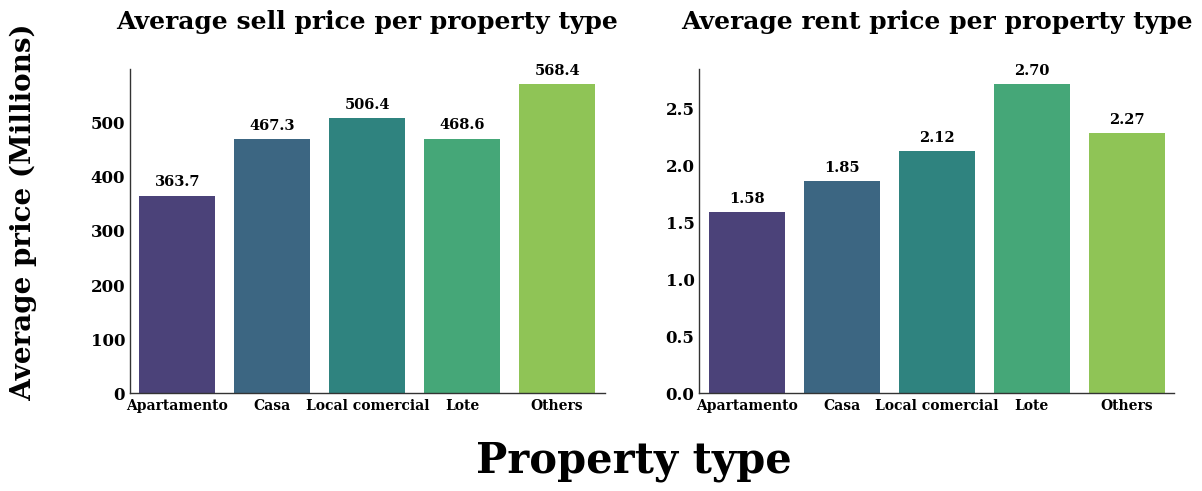

In [208]:
##Precio promedio por venta o arriendo


sell = df_gen2.loc[df_gen2['operation_type']=='Venta'].drop(columns='operation_type')
rent = df_gen2.loc[df_gen2['operation_type']=='Arriendo'].drop(columns='operation_type')

sell_price_property_type = sell.groupby('property_type')['price'].mean().reset_index().head(6)
rent_price_property_type = rent.groupby('property_type')['price'].mean().reset_index().head(6)

fig, ax = plt.subplots(figsize=(12,4),ncols=2)
fig.supxlabel('Property type',fontsize=30,y=-0.15)
fig.supylabel('  Average price (Millions)',fontsize=20,x=-0.02)

barra1 = sns.barplot(data=sell_price_property_type,x='property_type',y='price',hue='property_type',palette='viridis',ax=ax[0])
barra2 = sns.barplot(data=rent_price_property_type,x='property_type',y='price',hue='property_type',palette='viridis',ax=ax[1])

ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Average sell price per property type',y=1.1,fontsize=18)
ax[0].spines[['top','right']].set_visible(False)
ax[0].tick_params(axis='y',labelsize=12)

ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('Average rent price per property type',y=1.1,fontsize=18)
ax[1].spines[['top','right']].set_visible(False)
ax[1].tick_params(axis='y',labelsize=12)

# for x,y in enumerate(sell_price_property_type['price']):
#     ax[0].text(x,y+20,f'{y:.0f} \nmillions',va='bottom',ha='center')

# for x,y in enumerate(rent_price_property_type['price']):
#     ax[1].text(x,y+0.05,f'{y:.2f} \nmillions',va='bottom',ha='center')

for container in barra1.containers:
    barra1.bar_label(container, padding=5,fmt='%.1f')

for container in barra2.containers:
    barra2.bar_label(container, padding=5,fmt='%.2f')
plt.show()

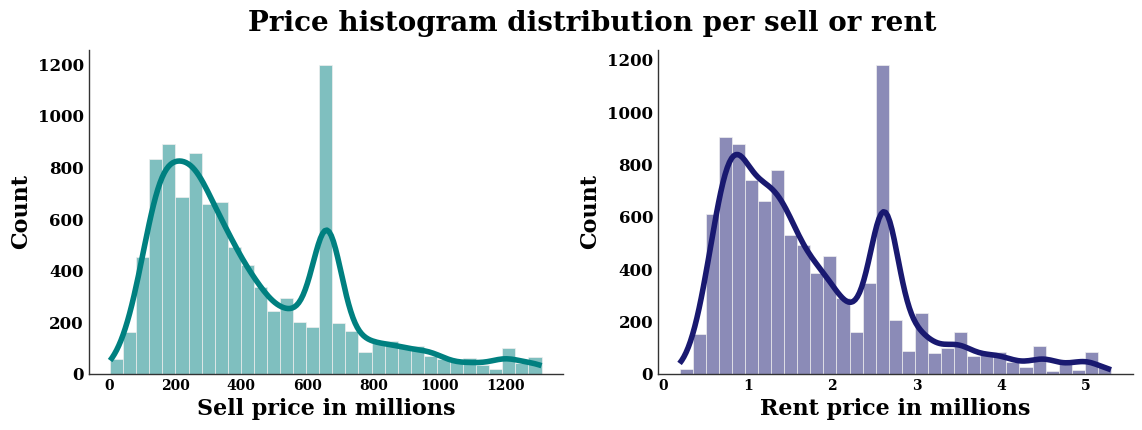

In [211]:
###Distribución de los precios separado por venta o arriendo

fig, ax = plt.subplots(ncols=2,figsize=(12,4))


fig.suptitle('Price histogram distribution per sell or rent')
sns.histplot(data=sell.sample(10000),x='price',ax=ax[0],color='teal',kde=True
)
sns.histplot(data=rent.sample(10000),x='price',ax=ax[1],color='midnightblue',kde=True
)

kind = ['Sell','Rent']
for i in range(2):
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_xlabel(f'{kind[i]} price in millions')
    ax[i].tick_params(axis='y',labelsize=12)

plt.show()

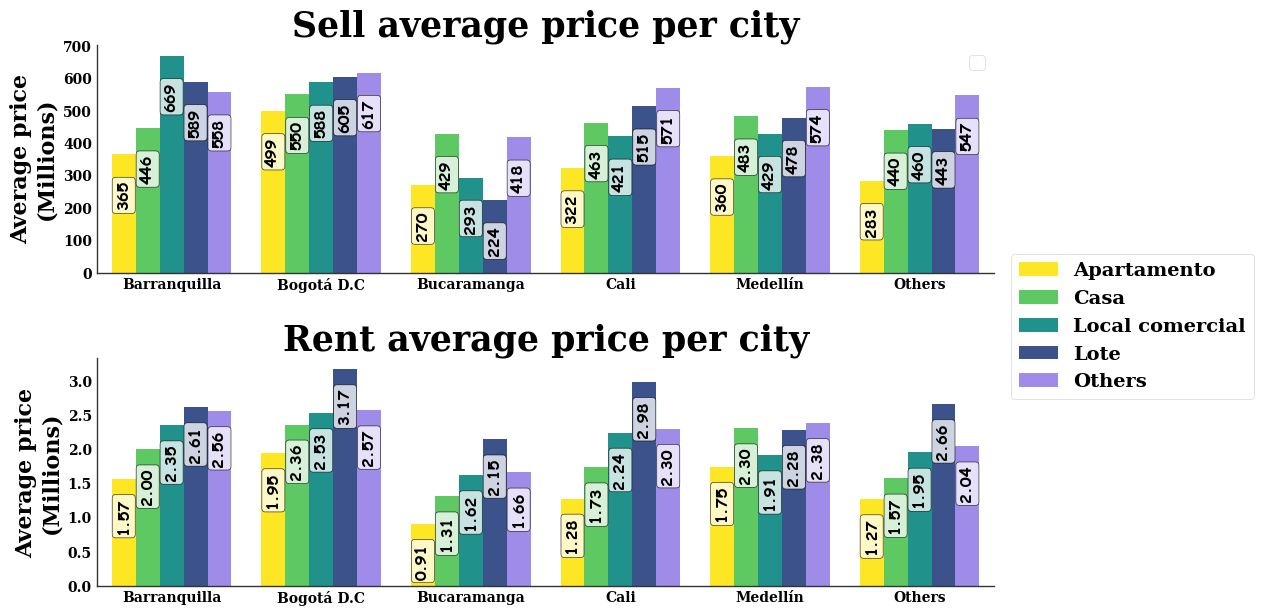

In [233]:
## Precio promedio de venta o arriendo separado por ciudad y tipo de inmueble

sell_price_city = sell.groupby(['City','property_type'])['price'].mean().reset_index()
rent_price_city = rent.groupby(['City','property_type'])['price'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10,6),nrows=2)
fig.tight_layout(h_pad=4)

colors = ['#fde725','#5ec962','#21918c','#3b528b','#9f8be8']
columnas = sell_price_city['property_type'].unique()
colores = {}
for i,col in enumerate(columnas):
    colores[col] = colors[i]
barra1 = sns.barplot(data=sell_price_city,x='City',y='price',hue='property_type',palette=colores,ax=ax[0],saturation=1)
barra2 = sns.barplot(data=rent_price_city,x='City',y='price',hue='property_type',palette=colores,ax=ax[1],saturation=1)

ax[0].legend('')
ax[1].legend(bbox_to_anchor=(1.3,1.5))

for i in range(2):
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Average price\n(Millions)')
    ax[i].set_title(f'{kind[i]} average price per city')
    ax[i].tick_params(axis='y',labelsize=10)

for container in barra1.containers:
        barra1.bar_label(container, fmt='%.0f', label_type='edge',rotation=90,padding=-40,
                         color='k',fontsize=11.5,bbox={'facecolor':'w','pad':1,'alpha':0.75,'edgecolor':'k','boxstyle':'round,pad=0.22'},fontfamily='cursive',fontweight='bold')
        
for container in barra2.containers:
        barra2.bar_label(container, fmt='%.2f', label_type='edge',rotation=90,padding=-40,
                         color='k',fontsize=11.5,bbox={'facecolor':'w','alpha':0.75,'edgecolor':'k','boxstyle':'round,pad=0.22'},fontfamily='cursive',fontweight='bold')
        



## Análisis específico

A partir de aquí la idea es analizar un subconjunto de datos donde tenemos información del área total de cada inmueble.

In [258]:
df_esp = df.dropna(subset='surface_total').drop(columns=['id','l1','created_on','ad_type','currency','title','description','price_period'])

###Obtención de la cantidad de valores nulos

missing_values(df_esp)

df_esp = df_esp.drop(columns=['l4','l5','l6']).reset_index(drop=True)

---------There are 3 columns with over 30% of missing values----------
start_date = 0.00%
end_date = 0.00%
lat = 5.55%
lon = 5.55%
l2 = 0.00%
l3 = 7.37%
l4 = 62.00%
l5 = 78.28%
l6 = 87.44%
rooms = 22.49%
bedrooms = 22.42%
bathrooms = 12.30%
surface_total = 0.00%
surface_covered = 5.84%
price = 0.38%
property_type = 0.00%
operation_type = 0.00%


In [259]:
## Conversión del tipo de dato

df_esp

,start_date,end_date,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,operation_type
0,2020-10-07,2020-10-25,4.621,-74.081,Cundinamarca,Bogotá D.C,NaN,NaN,NaN,220.0,383.0,5.900000e+08,Casa,Venta
1,2020-10-07,2020-10-09,3.440,-76.506,Valle del Cauca,Cali,3.0,3.0,1.0,85.0,85.0,1.500000e+08,Casa,Venta
2,2020-10-07,2020-10-09,6.159,-75.594,Antioquia,Envigado,3.0,3.0,1.0,100.0,100.0,9.500000e+05,Casa,Arriendo
3,2020-10-07,2020-11-13,7.920,-72.499,Norte de Santander,NaN,3.0,3.0,2.0,98.0,NaN,1.600000e+08,Casa,Venta
4,2020-10-07,2020-10-09,NaN,NaN,Norte de Santander,NaN,3.0,3.0,2.0,48.0,96.0,1.000000e+06,Casa,Arriendo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41237,2021-03-31,2021-05-10,4.735,-74.050,Cundinamarca,Bogotá D.C,1.0,1.0,1.0,190.0,190.0,6.700000e+06,Local comercial,Arriendo
41238,2021-03-31,2021-05-10,4.713,-74.070,Cundinamarca,Bogotá D.C,NaN,NaN,NaN,156.0,156.0,8.000000e+06,Local comercial,Arriendo
41239,2021-03-31,2021-05-10,4.710,-74.062,Cundinamarca,Bogotá D.C,NaN,NaN,1.0,102.0,102.0,1.500000e+09,Local comercial,Venta
41240,2021-03-31,2021-05-10,4.713,-74.070,Cundinamarca,Bogotá D.C,NaN,NaN,NaN,156.0,156.0,1.200000e+09,Local comercial,Venta


---------There are 3 columns with over 30% of missing values----------
start_date = 0.00%
end_date = 0.00%
lat = 5.55%
lon = 5.55%
l2 = 0.00%
l3 = 7.37%
l4 = 62.00%
l5 = 78.28%
l6 = 87.44%
rooms = 22.49%
bedrooms = 22.42%
bathrooms = 12.30%
surface_total = 0.00%
surface_covered = 5.84%
price = 0.38%
property_type = 0.00%
operation_type = 0.00%


{'l4': 62.00232772416469, 'l5': 78.28184860094079, 'l6': 87.43998836137918}

In [245]:
df_esp

,start_date,end_date,lat,lon,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_period,property_type,operation_type
171,2020-10-07,2020-10-25,4.621,-74.081,Cundinamarca,Bogotá D.C,Zona Centro,Los Mártires,NaN,NaN,NaN,NaN,220.0,383.0,5.900000e+08,NaN,Casa,Venta
183,2020-10-07,2020-10-09,3.440,-76.506,Valle del Cauca,Cali,NaN,NaN,NaN,3.0,3.0,1.0,85.0,85.0,1.500000e+08,NaN,Casa,Venta
201,2020-10-07,2020-10-09,6.159,-75.594,Antioquia,Envigado,NaN,NaN,NaN,3.0,3.0,1.0,100.0,100.0,9.500000e+05,NaN,Casa,Arriendo
394,2020-10-07,2020-11-13,7.920,-72.499,Norte de Santander,NaN,NaN,NaN,NaN,3.0,3.0,2.0,98.0,NaN,1.600000e+08,NaN,Casa,Venta
398,2020-10-07,2020-10-09,NaN,NaN,Norte de Santander,NaN,NaN,NaN,NaN,3.0,3.0,2.0,48.0,96.0,1.000000e+06,NaN,Casa,Arriendo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999877,2021-03-31,2021-05-10,4.735,-74.050,Cundinamarca,Bogotá D.C,Zona Noroccidental,NaN,NaN,1.0,1.0,1.0,190.0,190.0,6.700000e+06,NaN,Local comercial,Arriendo
999878,2021-03-31,2021-05-10,4.713,-74.070,Cundinamarca,Bogotá D.C,Zona Noroccidental,Suba,Niza,NaN,NaN,NaN,156.0,156.0,8.000000e+06,NaN,Local comercial,Arriendo
999879,2021-03-31,2021-05-10,4.710,-74.062,Cundinamarca,Bogotá D.C,Zona Noroccidental,Suba,Niza,NaN,NaN,1.0,102.0,102.0,1.500000e+09,NaN,Local comercial,Venta
999880,2021-03-31,2021-05-10,4.713,-74.070,Cundinamarca,Bogotá D.C,Zona Noroccidental,Suba,Niza,NaN,NaN,NaN,156.0,156.0,1.200000e+09,NaN,Local comercial,Venta


In [236]:
df['surface_total'].dropna()

171       220.0
183        85.0
201       100.0
394        98.0
398        48.0
          ...  
999877    190.0
999878    156.0
999879    102.0
999880    156.0
999988     62.0
Name: surface_total, Length: 41242, dtype: float64